In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import graphviz
from sklearn.datasets import load_breast_cancer
from gplearn.genetic import SymbolicClassifier

In [5]:
rng = check_random_state(0)
cancer = load_breast_cancer()   #加载该数乳腺癌据集，30个特征，标签有阳和阴
perm = rng.permutation(cancer.target.size) #随机生成一个size大小的排列
cancer.data = cancer.data[perm] #打乱顺序，重排一下
cancer.target = cancer.target[perm] #target表示y，即标签

In [6]:
est = SymbolicClassifier(parsimony_coefficient=.01,
                         feature_names=cancer.feature_names,
                         random_state=1)
est.fit(cancer.data[:400], cancer.target[:400])  #用前400个训练一下

SymbolicClassifier(feature_names=array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23'),
                   parsimony_coefficient=0.01, random_state=1)

In [8]:
from sklearn.metrics import roc_auc_score
y_true = cancer.target[400:]  #用后面的测一下效果
y_score = est.predict_proba(cancer.data[400:])[:,1]  #预测结果
roc_auc_score(y_true, y_score) #计算二分类的auc，与roc曲线有关

0.9693786982248521

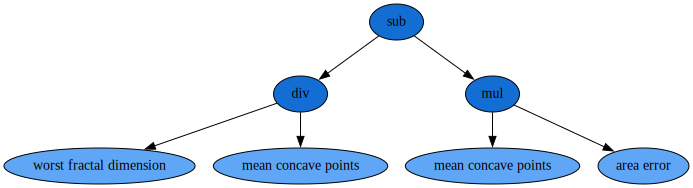

In [9]:
dot_data = est._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

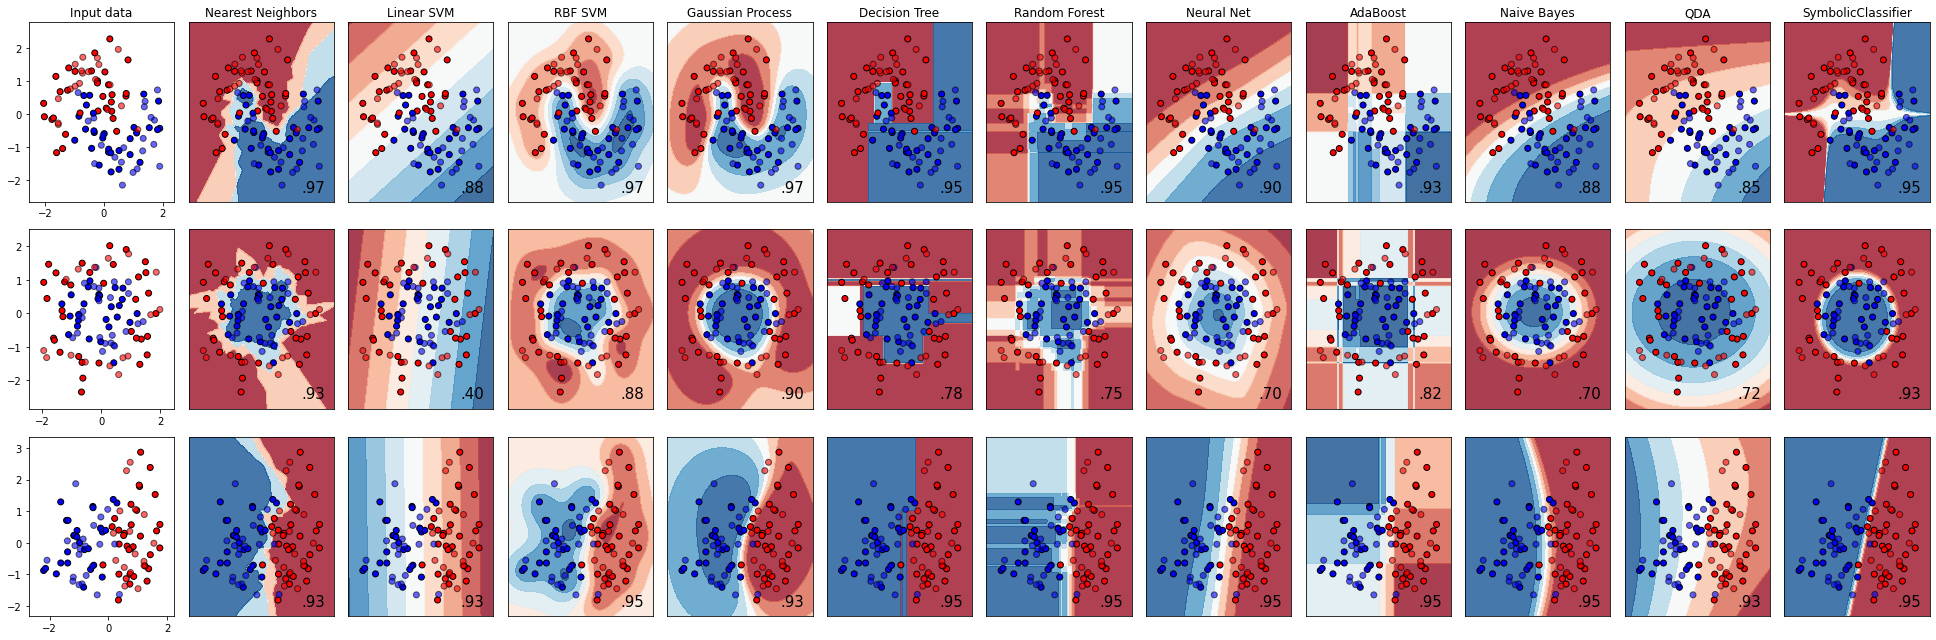

In [25]:
h = .02 #网格步长
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "SymbolicClassifier"]   #模型名称

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, tol=0.001),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    SymbolicClassifier(random_state=0)]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)    #随机生成一个n类分类的问题，这里是生成一个二分类问题

rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape) #X加上一个0~1之间的随机数。这是因为原数据集的两个簇距离太远，而且同簇间数据很紧密，不便于测试分类器的性能，所以加一个随机数让他们更加分散
linearly_separable = (X, y)
# plt.scatter(X[:,0],X[:,1])

datasets = [make_moons(noise=0.3, random_state=0),  #生成月亮型数据
            make_circles(noise=0.2, factor=0.5, random_state=1),  #生成圆形数据
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
#数据集的迭代
for ds_cnt, ds in enumerate(datasets):
    #数据预处理
    X, y = ds
    X = StandardScaler().fit_transform(X)  #归一化
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)  #将数据集分为测试集和验证集
    
    #这几步是为了生成网格
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    #先画出数据点
    cm = plt.cm.RdBu #绘制轮廓线时用到了
    cm_bright = ListedColormap(['#FF0000', '#0000FF']) #颜色图
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i) #画出点图
    if ds_cnt == 0:  #第一张图只有数据，所以加上title
        ax.set_title("Input data")
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')  #c是一个list，需要设置cmap
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')
    
    ax.set_xlim(xx.min(), xx.max()) 
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(()) #度量为空，即不显示横纵轴信息
    ax.set_yticks(())
    i += 1
    
    #遍历每个分类器
    for name, clf in zip(names, classifiers): #打包为元组的列表
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        
        #绘制决策边界，为每个对象分配一个颜色
        if hasattr(clf, "decision_function"):  #判断是否含有对象xxx
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) #衡量待预测样本到分类模型各个分隔超平面的距离
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]  #输出属于每个类别的概率，这里取正确的概率
        # 绘制轮廓线
        Z = Z.reshape(xx.shape) #对应xx的每个值
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
        
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()  #避免title和图片描述等重叠
plt.show()

In [28]:

print(xx)
print(yy)
print(xx.ravel().shape)
print(yy.ravel().shape)
np.c_[xx.ravel(), yy.ravel()].shape

[[-2.69997218 -2.67997218 -2.65997218 ...  2.20002782  2.22002782
   2.24002782]
 [-2.69997218 -2.67997218 -2.65997218 ...  2.20002782  2.22002782
   2.24002782]
 [-2.69997218 -2.67997218 -2.65997218 ...  2.20002782  2.22002782
   2.24002782]
 ...
 [-2.69997218 -2.67997218 -2.65997218 ...  2.20002782  2.22002782
   2.24002782]
 [-2.69997218 -2.67997218 -2.65997218 ...  2.20002782  2.22002782
   2.24002782]
 [-2.69997218 -2.67997218 -2.65997218 ...  2.20002782  2.22002782
   2.24002782]]
[[-2.31370696 -2.31370696 -2.31370696 ... -2.31370696 -2.31370696
  -2.31370696]
 [-2.29370696 -2.29370696 -2.29370696 ... -2.29370696 -2.29370696
  -2.29370696]
 [-2.27370696 -2.27370696 -2.27370696 ... -2.27370696 -2.27370696
  -2.27370696]
 ...
 [ 3.32629304  3.32629304  3.32629304 ...  3.32629304  3.32629304
   3.32629304]
 [ 3.34629304  3.34629304  3.34629304 ...  3.34629304  3.34629304
   3.34629304]
 [ 3.36629304  3.36629304  3.36629304 ...  3.36629304  3.36629304
   3.36629304]]
(70680,)
(70680,

(70680, 2)